In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
df_lstm_pred = pd.read_csv("volatility_predictions.csv", index_col=0, parse_dates=True)
df_lstm_pred = df_lstm_pred.sort_index()

In [3]:
sequence_length = 90  # Increase to 90 days instead of 60


In [4]:
# Normalize the 'Rolling_Volatility' for LSTM training
scaler = MinMaxScaler()
df_lstm_pred['Scaled_Volatility'] = scaler.fit_transform(df_lstm_pred[['Rolling_Volatility']])


In [5]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(df_lstm_pred['Scaled_Volatility'].values, sequence_length)

# Split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape for LSTM input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [6]:
# === Build LSTM Model ===
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(1)
])


model.compile(optimizer='adam', loss='mean_squared_error')


In [7]:
history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_data=(X_test, y_test), verbose=1)


Epoch 1/150
124/124 [==============================] - 19s 125ms/step - loss: 0.3348 - val_loss: 0.0133
Epoch 2/150
124/124 [==============================] - 15s 118ms/step - loss: 0.1098 - val_loss: 0.0081
Epoch 3/150
124/124 [==============================] - 15s 119ms/step - loss: 0.0543 - val_loss: 0.0099
Epoch 4/150
124/124 [==============================] - 14s 117ms/step - loss: 0.0358 - val_loss: 0.0041
Epoch 5/150
124/124 [==============================] - 14s 116ms/step - loss: 0.0227 - val_loss: 6.8755e-04
Epoch 6/150
124/124 [==============================] - 14s 115ms/step - loss: 0.0193 - val_loss: 0.0037
Epoch 7/150
124/124 [==============================] - 14s 115ms/step - loss: 0.0138 - val_loss: 0.0024
Epoch 8/150
124/124 [==============================] - 15s 117ms/step - loss: 0.0109 - val_loss: 0.0016
Epoch 9/150
124/124 [==============================] - 14s 113ms/step - loss: 0.0085 - val_loss: 0.0071
Epoch 10/150
124/124 [==============================] - 14s 

In [8]:
# === Make Predictions ===
predicted_volatility = model.predict(X_test)

16/16 [==============================] - 1s 49ms/step


In [9]:
# Reverse scale the predictions
predicted_volatility = scaler.inverse_transform(predicted_volatility.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


In [10]:
# === Create a new DataFrame for plotting results ===
# The test set covers the final len(y_test) points in df_lstm_pred
df_lstm_results = pd.DataFrame({
    "Date": df_lstm_pred.index[-len(y_test):],  # Match test set length
    "Predicted Volatility (LSTM)": predicted_volatility.flatten(),
    "Actual Volatility": y_test_actual.flatten()
})

In [11]:
# Set "Date" as the index
df_lstm_results.set_index("Date", inplace=True)

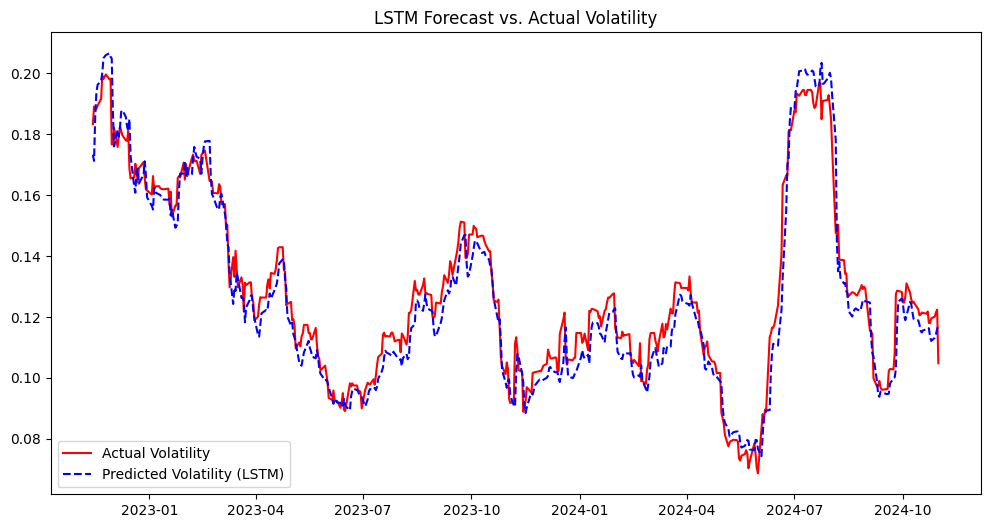

In [12]:
# === Plot Actual vs. Predicted Volatility ===
plt.figure(figsize=(12, 6))
plt.plot(df_lstm_results.index, df_lstm_results["Actual Volatility"], 
         label="Actual Volatility", color="red")
plt.plot(df_lstm_results.index, df_lstm_results["Predicted Volatility (LSTM)"], 
         label="Predicted Volatility (LSTM)", color="blue", linestyle="dashed")
plt.title("LSTM Forecast vs. Actual Volatility")
plt.legend()
plt.show()

In [13]:
# Save model
model.save("lstm_volatility_model.h5")
print("LSTM model saved!")


LSTM model saved!


In [14]:
# Save LSTM predictions
df_lstm_results = pd.DataFrame({
    "Date": df_lstm_pred.index[-len(y_test):],  # Match test set length
    "Predicted Volatility (LSTM)": predicted_volatility.flatten(),
    "Actual Volatility": y_test_actual.flatten()
})

df_lstm_results.set_index("Date", inplace=True)
df_lstm_results.to_csv("lstm_volatility_predictions.csv")

print("Improved LSTM predictions saved to 'improved_lstm_predictions.csv'")


Improved LSTM predictions saved to 'improved_lstm_predictions.csv'


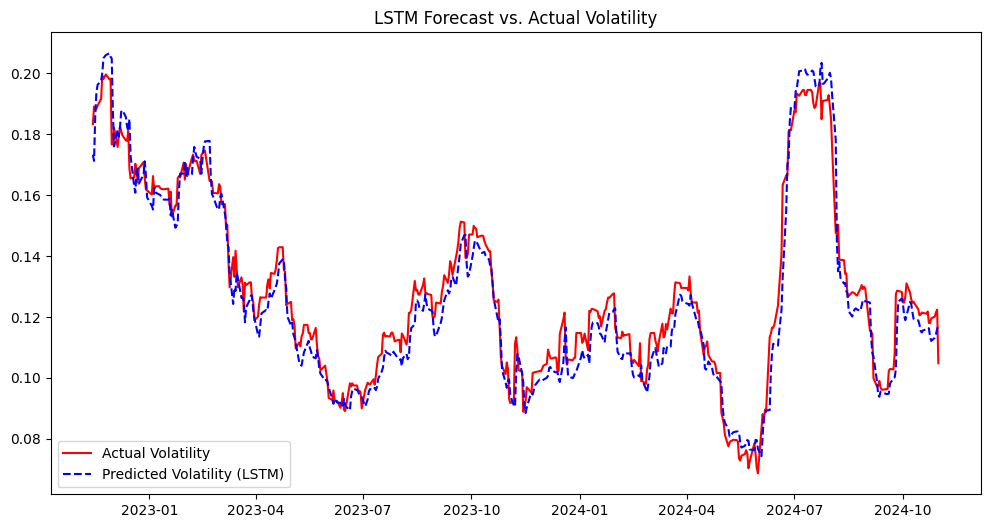

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df_lstm_results.index, df_lstm_results["Actual Volatility"], label="Actual Volatility", color="red")
plt.plot(df_lstm_results.index, df_lstm_results["Predicted Volatility (LSTM)"], label="Predicted Volatility (LSTM)", color="blue", linestyle="dashed")
plt.title("LSTM Forecast vs. Actual Volatility")
plt.legend()
plt.show()

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0
